# GANS/Cyclic GANS For Data Augmentation and Neural Style Transfer

In [64]:
import tensorflow as tf
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil
import random
import itertools
import math
import time

from skimage.io import imread
from skimage.transform import resize

# Model class
from tensorflow.keras.models import Model

# Layers
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, Dropout, Flatten, Conv2D, Dense, MaxPool2D, Conv2DTranspose, GlobalMaxPool2D, Reshape, BatchNormalization, Input

# Optimizer
from tensorflow.keras.optimizers import Adam

# Loss function
from tensorflow.keras.losses import BinaryCrossentropy

# Data loader
from tensorflow.keras.utils import Sequence

# Metrics
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision, MSE

# ImageLoader
from skimage.io import imread

# Weights Initializer
from tensorflow.keras.initializers import RandomNormal, GlorotNormal, GlorotUniform

## Getting The Data

In [2]:
def split_data(data_dir, split):
    
    dirs = split.keys()
    # get existing folders names 
    subdirs = [x for x in os.listdir(data_dir) if x not in dirs]
    
    # filling dataset structure
    dataset_dir_structure = {}
    
    for dir_ in dirs:
        dataset_dir_structure[dir_] = subdirs
        
    for key, val in dataset_dir_structure.items():
        if isinstance(val, list):
            for sub_key in val:
                Path(Path(data_dir) / key /
                     sub_key).mkdir(exist_ok=True, parents=True)
    
    cat_images = glob.glob(f"{data_dir}/Cat/*.jpg")
    dog_images = glob.glob(f"{data_dir}/Dog/*.jpg")
    
    assert sum(list(split.values())) < (len(cat_images)+len(dog_images)), f"Split values should not excceed number of datapoints: {sum(list(split.values()))} > {(len(cat_images)+len(dog_images))}"
    
    for split_dir in split.keys():
        for i in range(int(split[split_dir]/2)):
            cat_im = np.random.choice(cat_images)
            shutil.copy(cat_im, f"{data_dir}/{split_dir}/Cat/{i}.jpg")
            cat_images.remove(cat_im)
        
            dog_im = np.random.choice(dog_images)
            shutil.copy(dog_im, f"{data_dir}/{split_dir}/Dog/{i}.jpg")
            dog_images.remove(dog_im)

In [3]:
split_data("PetImages", {"train": 2500, "test": 500})

## Pre-Processing The Data

In [4]:
# create a dataloader iterator that loads data from directory
# batch data
# resize to all the same size
# split train test
# normalize (min-max)

In [3]:
class DataLoader(Sequence):
    
    def __init__(self, im_dir, labels= None, batch_size= 32, resize= False, output_dim= None, classification= True, shuffle= True):
        
        self.im_dir = im_dir
        self.classification = classification
        self.shuffle = shuffle
        self.resize = resize
        self.output_dim = output_dim
        self.batch_size = batch_size
        
        self.labels = {}
        if isinstance(labels, list):
            for i, label in enumerate(labels):
                self.labels[label] = i
        elif isinstance(labels, dict):
            self.labels = labels
        else:
            for root_dir, subdirs, files in os.walk(self.im_dir):
                for i, subdir in enumerate(subdirs):
                    self.labels[subdir] = i
        
            
        self.images = glob.glob(f"{self.im_dir}/*/*")
        random.shuffle(self.images)
        
        self.on_epoch_end()
        
    
    def __len__(self):
        return int(np.floor(len(self.images)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        im_files_batch = [self.images[idx] for idx in indexes]
        if self.resize:
            batch_images = np.array([resize(imread(file), self.output_dim, preserve_range= True) for file in im_files_batch], dtype= np.uint8)
            batch_images = (np.asanyarray(batch_images, dtype= np.float32) - 127.5)/127.5
        else:
            batch_images = np.arrary([imread(file) for file in im_files_batch], dtype= np.uint8)
        
        batch_labels = np.empty((self.batch_size), dtype= np.int8)
        for i, im in enumerate(im_files_batch):
            for label in self.labels.keys():
                if label in im:
                    batch_labels[i] = self.labels[label]
        return batch_images, batch_labels
    
    def on_epoch_end(self):
        "Updates all indexes after the end of each epoch"
        self.indexes = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
        
    def add_data(self, batched_data):
        return

In [4]:
train_cat_dog_data = DataLoader(im_dir= "dataset/PetImages/train", resize= True, output_dim= (200, 200, 3))
val_cat_dog_data = DataLoader(im_dir= "dataset/PetImages/test", resize= True, output_dim= (200, 200, 3))

Show a bit more of the data

## Define Metrics For Classification
- Accuracy
- Precision
- Recall

In [162]:
def show_metrics_classification(model_history):
    metrics = [metric for metric in model_history.history.keys() if "val" not in metric]
    
    colors = list(itertools.combinations(['b', 'g', 'r', 'c', 'm', 'y', 'k'], 2))
    
    f = plt.figure()
    f.set_figwidth(2.5*len(metrics))
    f.set_figheight(3*len(metrics))
    for i, metric in enumerate(metrics):
        plt.subplot(math.ceil(len(metrics)/2), 2, i+1)
        color_plts = np.random.randint(0, len(colors))
        plt.plot(model_history.history[metric], color= colors[color_plts][0])
        plt.plot(model_history.history[f"val_{metric}"], color= colors[color_plts][1])
        plt.ylabel(metric)
        plt.xlabel("epochs")
        plt.legend(["train", "val"], loc= "upper left")
        plt.title(f"{metric.title()} vs Epochs")
    plt.show()
    

## Building The Classifier

In [100]:
class Classifier(Model):
    
    def __init__(self, name):
        super(Classifier, self).__init__(name= name)
        
    def build(self, input_shape):
        
        self.conv1 = Conv2D(filters= 50, kernel_size= 3, activation= 'relu', padding= 'same', kernel_initializer= 'glorot_uniform', input_shape= input_shape)
        self.maxpool1 = MaxPool2D(pool_size= (2, 2))
        
        self.conv2 = Conv2D(filters= 20, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool2 = MaxPool2D(pool_size= (2, 2))
        
        self.conv3 = Conv2D(filters= 5, kernel_size= 3, activation= 'relu', padding= 'valid', kernel_initializer= 'glorot_uniform')
        self.maxpool3 = MaxPool2D(pool_size= (2, 2))
        
        self.flatten = Flatten()
        self.dense1 = Dense(units= 30, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense2 = Dense(units= 20, activation= 'relu', kernel_initializer= 'glorot_uniform')
        self.dense3 = Dense(units= 1, activation= 'sigmoid', kernel_initializer= 'glorot_uniform')
        
        super(Classifier, self).build(input_shape)
    
    def call(self, input_):
        x = self.conv1(input_)
        x = self.maxpool1(x)
        
        x = self.conv2(x)
        x = self.maxpool2(x)
        
        x = self.conv3(x)
        x = self.maxpool3(x)
     
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        
        output = self.dense3(x)
        return output
    
    def train_step(self, train_batch):
        X_train, y_train = train_batch
        
        with tf.GradientTape() as tape:
            # apply forward pass
            y_pred = self(X_train, training= True)
            loss = self.compiled_loss(y_train, y_pred, regularization_losses= self.losses)
        # calculate gradients - uses reverse gradient autodiff
        gradients = tape.gradient(loss, self.trainable_variables)
        # backpropagate the gradients and update the weights using the compiled optimizer
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        self.compiled_metrics.update_state(y_train, y_pred)
        return {f"train_{metric.name}": metric.result() for metric in self.metrics}
    
    def test_step(self, test_batch):
        X_test, y_test = test_batch
        # obtain prediciton
        y_pred = self(X_test, training= False)
        
        # updates loss metric
        self.compiled_loss(y_test, y_pred)
        
        # updates metrics
        self.compiled_metrics.update_state(y_test, y_pred)
        
        return {f"{metric.name}": metric.result() for metric in self.metrics}

## Traning the Classifier

In [155]:
tf.keras.backend.clear_session()
with tf.device('/device:GPU:0'):
    
    cats_dogs_classifier = Classifier(name= "cvd")
    cats_dogs_classifier.build(input_shape= (None, 200, 200, 3))

    cats_dogs_classifier.summary()
    cats_dogs_classifier.compile(optimizer= Adam(0.001), loss= BinaryCrossentropy(), metrics= [BinaryAccuracy(), Recall(), Precision(), MSE])
    model_data = cats_dogs_classifier.fit(train_cat_dog_data, validation_data= val_cat_dog_data, epochs= 10, workers= 10, use_multiprocessing= False)

Model: "cvd"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9020      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  905       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0       

C:\Users\Charb\anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


78/78 [==============================] - 14s 150ms/step - batch: 38.5000 - size: 32.0000 - loss: 0.6947 - binary_accuracy: 0.5068 - recall: 0.3702 - precision: 0.5094 - mean_squared_error: 0.2507 - val_loss: 0.6932 - val_binary_accuracy: 0.4958 - val_recall: 0.0041 - val_precision: 0.5000 - val_mean_squared_error: 0.2500
Epoch 2/10
78/78 [==============================] - 11s 149ms/step - batch: 38.5000 - size: 32.0000 - loss: 0.6896 - binary_accuracy: 0.5164 - recall: 0.1995 - precision: 0.5449 - mean_squared_error: 0.2483 - val_loss: 0.6814 - val_binary_accuracy: 0.5917 - val_recall: 0.5207 - val_precision: 0.6117 - val_mean_squared_error: 0.2443
Epoch 3/10
78/78 [==============================] - 11s 148ms/step - batch: 38.5000 - size: 32.0000 - loss: 0.6797 - binary_accuracy: 0.5753 - recall: 0.6501 - precision: 0.5649 - mean_squared_error: 0.2429 - val_loss: 0.6801 - val_binary_accuracy: 0.5667 - val_recall: 0.5537 - val_precision: 0.5726 - val_mean_squared_error: 0.2438
Epoch 4/1

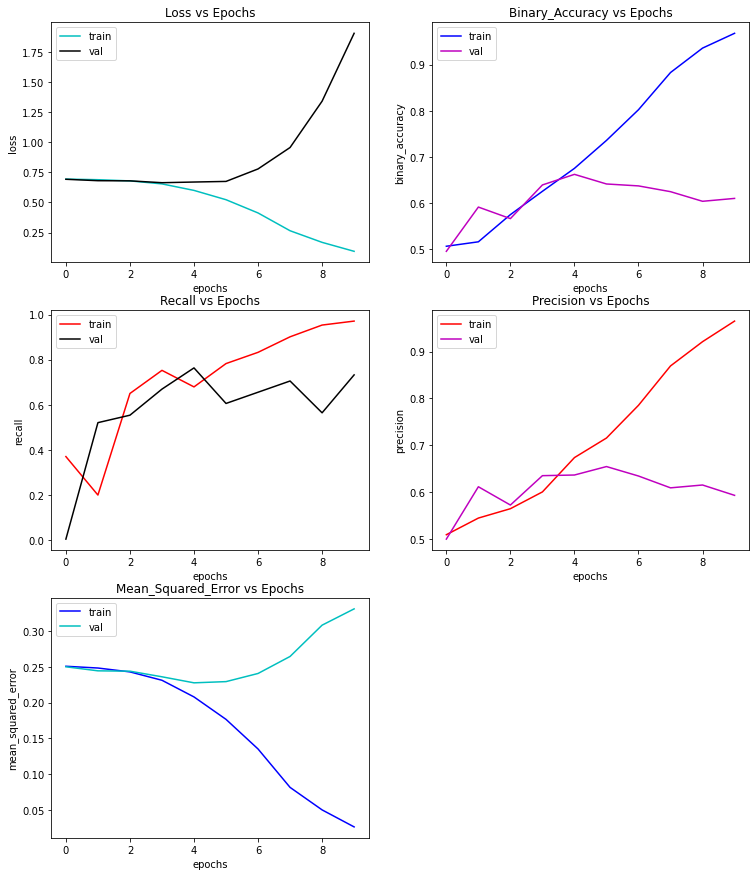

In [163]:
show_metrics_classification(cats_dogs_classifier.history)

## GAN

### Building The GAN Architecture
#### Generator

In [6]:
class Generator(Model):
    def __init__(self, name):
        super(Generator, self).__init__(name= name)
        
    def build(self, input_shape):
        self.dense1 = Dense(25*25*128, input_shape= (128,), use_bias= False)
        self.reshape = Reshape((25, 25, 128))
        self.convt1 = Conv2DTranspose(128, (3, 3), strides= 2, padding= "same", use_bias= False)
        self.convt2 = Conv2DTranspose(128, (3, 3), strides= 2, padding= "same", use_bias= False)
        self.convt3 = Conv2DTranspose(3, (3, 3), strides= 2, padding= "same", activation= "tanh", use_bias= False)
        
        super(Generator, self).build(input_shape)

    
    def call(self, inputs_):
        x = self.dense1(inputs_)
        x = BatchNormalization()(x)
        x = tf.nn.leaky_relu(x)
        x = self.reshape(x)
        
        x = self.convt1(x)
        x = tf.nn.leaky_relu(x)
        
        x = self.convt2(x)
        x = tf.nn.leaky_relu(x)
        
        output = self.convt3(x)
        return output
        

#### Discriminator

In [7]:
class Discriminator(Model):
    def __init__(self, name):
        super(Discriminator, self).__init__(name= name)
    
    def build(self, input_shape):
        self.conv1 = Conv2D(64, (3, 3), strides= 2, padding= "same", activation= "relu")
        self.conv2 = Conv2D(64, (3, 3), strides= 2, padding= "same", activation= "relu")
        #self.max_pool = MaxPool2D(pool_size= (2, 2))
        self.conv3 = Conv2D(64, (3, 3), strides= 2, padding= "same", activation= "relu")
        #self.conv4 = Conv2D(128, (3, 3), strides= 2, padding= "same", activation= "relu")

        self.glob_pool = GlobalMaxPool2D()
        self.dense1 = Dense(1)
        
        super(Discriminator, self).build(input_shape)

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv2(x)
        #x = self.max_pool(x)
        x = self.conv3(x)
        #x = self.conv4(x)
        x = self.glob_pool(x)
        output = self.dense1(x)
        return output

#### GAN

In [8]:
class GAN(Model):
    def __init__(self, discriminator: Discriminator, generator: Generator, name):
        super(GAN, self).__init__(name= name)
        self.discriminator = discriminator
        self.generator = generator
    
    def compile(self, g_opt, disc_opt, loss_fun, run_eagerly= False):
        super(GAN, self).compile(run_eagerly= run_eagerly)
        self.g_opt = g_opt
        self.disc_opt = disc_opt
        self.loss_fn = loss_fun
        
    
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space

        batch_size = real_images.shape[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))
        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        
        # Add random noise to the labels - important trick!
        #labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        # Train the discriminator
        with tf.GradientTape() as tape:
            
            predictions = self.discriminator(combined_images)
            
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.disc_opt.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        
        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, 128))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))
        
        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_opt.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [9]:
generator = Generator(name= "Generator")
discriminator = Discriminator(name= "Discriminator")
gan = GAN(discriminator, generator,name= "gan")

In [13]:
gan.compile(Adam(learning_rate= 0.01), Adam(learning_rate= 0.01), BinaryCrossentropy(), run_eagerly= True)
hist = gan.fit(train_cat_dog_data, epochs= 3, workers= 10)

NotImplementedError: When subclassing the `Model` class, you should implement a `call` method.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


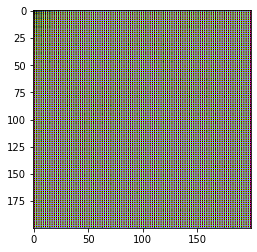

In [497]:
b = tf.random.normal(shape=(1, 128))
gen_image = generator(b)
gen_image.shape
plt.imshow(gen_image[0, :, :, :])

In [451]:
batch_size = 2
a = tf.random.normal(shape=(batch_size, 200, 200, 3))

In [534]:
batch_size_a = tf.shape(a)[0]
print(batch_size_a)
b = tf.random.normal(shape=(batch_size_a, 130))


tf.Tensor(2, shape=(), dtype=int32)


In [65]:
randNormal = GlorotUniform()

In [66]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,), kernel_initializer= randNormal))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False, kernel_initializer= randNormal))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False, kernel_initializer= randNormal))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh', kernel_initializer= randNormal))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [67]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1], kernel_initializer= randNormal))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same', kernel_initializer= randNormal))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1, kernel_initializer= randNormal))

    return model

In [68]:
cross_entropy = BinaryCrossentropy()

In [69]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [70]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [71]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [72]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [73]:
EPOCHS = 1000
BUFFER_SIZE = 60000
BATCH_SIZE = 64
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [74]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    if isinstance(images, tuple):
        images = images[0]
    noise = tf.random.normal([64, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return f"g_loss: {gen_loss}, disc_loss: {disc_loss}"

In [75]:
from IPython import display

In [76]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

    for image_batch in dataset:
        train_step(image_batch)

    # Save the model every 15 epochs
    """if (epoch + 1) % 15 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)"""

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

In [77]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [78]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

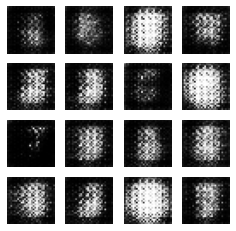

In [79]:
train(train_dataset, EPOCHS)

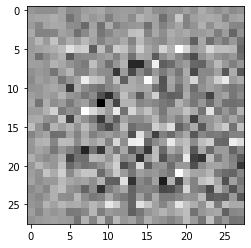

In [32]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [33]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00229267]], shape=(1, 1), dtype=float32)
